In [1]:
# Data-driven Newsvendor with Pricing
import numpy as np
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
from sklearn import linear_model
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Initalization
p = [] #price 
D = [] #demand


#Numerical experiment parameters
a = 0 #y-intercept or market size
b = 0 #coefficient of price
u = [] #estimation error term sampling
sigma = 0 #std of estimation error terms sampling

n = 250 #sample size
cv = 0.5 #coefficient of variance
c = 0.5 #procurement cost per unit
alpha = 0.9 #non-stockout probability

##Sampling range
lbp = 1 #lower bound of price
ubp = 1.5 #upper bound of price
lba = 1500 #lb of a
uba = 2000 #up of a
lbb = 500 #lb of b
ubb = 1000 #ub of b

# IMPLEMENTATION

We can divide the main problem into two subproblems as follows:  
1) to learn the relationship between demand/ ordering quantity and price   
2) to find optimal quantity and price   


## DEMAND/ ORDERING QUANTITY ESTIMATION (BEUTEL 2012)

**Reference:** Beutel, A. L., & Minner, S. (2012). *Safety stock planning under causal demand forecasting*. International Journal of Production Economics, 140(2), 637-645.

### Function to generate sampling of demand and price:
Demand is presented here as a function of price p: D(p) = a - b\*p + u.  
Demand - price observation set is built by randomly choose a, b, p and u. In more detail:
- market size a ~ U(1500, 2000)
- slope b ~ U(500, 1000)
- uniformly chosen sample of price p (with size = sampleSize) in range [1, 1.5] 
- D equals to the sum of prediction value plus estimation error u ~ N(0, sigma). Sigma is chosen so that the coefficient of variation at mean price p equals coefVar.

It should be noticed that here we will focus on the case that demand is relatively elastic with price. The reason is that in case of relatively price elasticity, demand responds weakly with the changes of price. Therefore, the vendor has the incentive to increase price as much as possible while only facing a little decrease in demand quantity. Combining with a ratio between overage and underage cost that is low enough (co < cu), it may lead to an ordering quantity function increasing with price increase and an unbound problem in price-setting newsvendor problem. Therefore, in the sampling generation function, we will reject the sample with relatively low price elasticity (<1) by checking the arc elasticity over the defined price range from OLS linear regression demand function.


In [3]:
# Demand - Price sampling generation function
def samplingDemand(sampleSize, coefVar):
    
    global a, b, p, D, u, sigma
    a = 0; b = 0; p = []; D = []; u = []; sigma = 0;
    
    lowElasticity = True
    while lowElasticity:
        # uniformly choose a, b, p in previously defined range
        a = np.random.uniform(low = lba, high = uba)
        b = np.random.uniform(low = lbb, high = ubb)
        p = np.random.uniform(size = [sampleSize, 1])*(ubp - lbp) + lbp 

        meanP = np.mean(p)
        sigma = (a - b*meanP)*coefVar #choose sigma to get defined cv at mean price
        u = np.zeros(shape = (sampleSize,))
        D = np.repeat(-1, repeats = sampleSize)
        for i in range(sampleSize):
            while D[i] < 0:
                u[i] = np.random.normal(loc = 0, scale = sigma) #normaly choose u
                D[i] = a - b*p[i] + u[i] #D = a -bp + u
 
        #check Arc price elasticity of obtained demand sampling
        #OLS regression 
        reg = linear_model.LinearRegression().fit(p, D)
        coef2 = reg.coef_
        coef1 = reg.intercept_
        Q1 = coef1 + coef2*lbp
        Q2 = coef1 + coef2*ubp
        arcElasticity = ((lbp + ubp) / (Q1 + Q2)) * ((Q2 - Q1) / (ubp - lbp))
        if abs(arcElasticity) >= 1: lowElasticity = False
    
    return coef1, coef2

Sampling example:

Text(0.5, 1.0, 'Demand sampling')

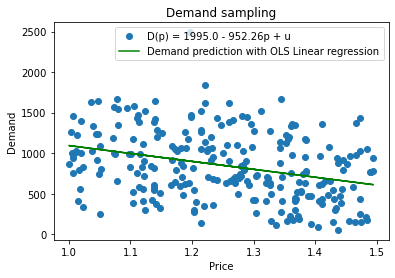

In [4]:
coef1, coef2 = samplingDemand(sampleSize = n, coefVar = cv)
plt.plot(p,D, 'o', label = 'D(p) = ' + str(round(a,0)) + ' - ' + str(round(b,2)) + 'p + u')
plt.plot(p, coef1 + coef2*p, 'g-', label = 'Demand prediction with OLS Linear regression')
plt.legend(loc = 8)
plt.xlabel('Price')
plt.ylabel('Demand')
plt.legend()
plt.title('Demand sampling')

### Optimization model to find the ordering quantity as a function of price
Here we use the approach presented in Beutel (2012) that integrates demand estimation and ordering optimization in a single model (instead of sequential steps) to learn about the relationship between ordering quantity and price. The main idea is to predict the ordering quantity by exploring historical data of demand-price with consideration of the overage and underage costs during estimating (i.e. different weights applied to the positive/negative errors in regression).  
  
There is a slight difference in two models below to the base models in Beutel (2012). In her models, Beutel assumes fixed holding cost and penalty cost, representing the overage and underage cost respectively. In other words, these costs are **independent with selling price**. However, here we will define the overage and underage cost as in the traditional newsvendor model, i.e.:     
- overage cost (co) = procurement cost (c)
- underage cost (cu) = selling price - procurement cost (p-c)

Therefore, the underage cost and so the critical fractile **depends on the selling price**. This modification is to match with the model in the second step and is more logical especially when considering the context of price-setting newsvendor, since it causes the trade-off characteristic in price decision. For example, increasing price affects the total cost (expected profit) in both positive way by decreasing underage cost (increasing revenue) per unit and negative way by decreasing demand.


Two following models assume ordering quantity is a linear function of the price: *q = beta0 + beta1 * p*. The decision variables in these models are the coefficients beta0 and beta1, as well as the waste (overage) and shortage (underage) for each demand observation. The objective function is considered as a cost minimization objective or with a service level constraint in each model.

#### The cost model

In [5]:
# Cost model
def costModel(sampleSize, procurementCost):
    
    baseCostModel = gp.Model("Base Cost model")

    #### Variables
    betaC0 = baseCostModel.addVar(lb = - GRB.INFINITY, vtype = GRB.CONTINUOUS) #~ beta0
    betaC1 = baseCostModel.addVar(lb = - GRB.INFINITY, vtype = GRB.CONTINUOUS) #~ beta1

    waste = {} # = q - D (overage)
    shortage = {} # = D - q (underage)
    sales = {} # = min(D, q)
    for i in range(sampleSize):
        #overage cost per unit (co) = c
        waste[i] = baseCostModel.addVar(lb = 0, vtype = GRB.CONTINUOUS, obj = procurementCost) 
        #underage cost per unit (cu) = p-c 
        shortage[i] = baseCostModel.addVar(lb = 0, vtype = GRB.CONTINUOUS, obj = p[i] - procurementCost)

        sales[i] = baseCostModel.addVar(lb = 0, vtype = GRB.CONTINUOUS)

    #### Constraints
    for i in range(sampleSize):
        baseCostModel.addConstr(shortage[i] == D[i] - sales[i]) #shortage = D - min(D, q) >= 0
        baseCostModel.addConstr(waste[i] >= betaC0 + betaC1 * p[i] - D[i]) #waste = max(0, q-D)
        baseCostModel.addConstr(sales[i] <= D[i]) #sales = min(D,q)
        baseCostModel.addConstr(sales[i] <= betaC0 + betaC1 * p[i])
        
    baseCostModel.Params.OutputFlag = 0 #not print Gurobi output to reduce memory
    baseCostModel.optimize()
    obj = baseCostModel.objVal; beta0 = betaC0.x; beta1 = betaC1.x;
    baseCostModel.dispose()
    
    return obj, beta0, beta1

Example of ordering quantity function with Cost model

Using license file C:\Users\xuanson\gurobi.lic
Academic license - for non-commercial use only
Objective: 49385.09377872202
Estimation of a: 1585.179545198668
Estimation of b: -536.4757256997037

Ordering quantity - price function: q =  1585.0 + -536.48 * p


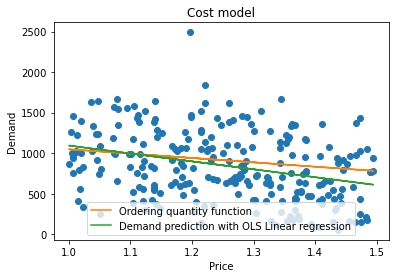

In [6]:
objC, betaC0, betaC1 = costModel(sampleSize = n, procurementCost = c)
print("Objective:",objC)
print('Estimation of a:', betaC0)
print('Estimation of b:', betaC1)

print('\nOrdering quantity - price function: q = ', round(betaC0,0),'+', round(betaC1,2),'* p')


#Plot
plt.plot(p,D,'o')
plt.plot(p, betaC0 + betaC1*p, label='Ordering quantity function')
plt.plot(p, coef1 + coef2*p, label = 'Demand prediction with OLS Linear regression')
plt.legend(loc = 8)
plt.xlabel('Price')
plt.ylabel('Demand')
plt.title('Cost model')
plt.show()

#### The service level model

In [7]:
# Service level model
def SLModel(sampleSize, procurementCost, nonStockOut):
    
    baseSLModel = gp.Model("Base Service level model")

    #### Variables
    betaSL0 = baseSLModel.addVar(lb = - GRB.INFINITY, vtype = GRB.CONTINUOUS) # ~ beta0
    betaSL1 = baseSLModel.addVar(lb = - GRB.INFINITY, vtype = GRB.CONTINUOUS) # ~ beta1

    waste = {}
    sales = {}
    unfulfilled = {} # binary variable: = 1 if D > q (underage, unfulfilled demand existing), = 0 otherwise
    for i in range(sampleSize):
        waste[i] = baseSLModel.addVar(lb = 0, vtype = GRB.CONTINUOUS, obj = procurementCost)   
        sales[i] = baseSLModel.addVar(lb = 0, vtype = GRB.CONTINUOUS)
        unfulfilled[i] = baseSLModel.addVar(vtype = GRB.BINARY)

    #### Constraints
    for i in range(sampleSize): #same as Cost model
        baseSLModel.addConstr(waste[i] >= betaSL0 + betaSL1 * p[i] - D[i])
        baseSLModel.addConstr(sales[i] <= D[i])
        baseSLModel.addConstr(sales[i] <= betaSL0 + betaSL1 * p[i])

        #if D < q then unfulfilled must equal to 1
        baseSLModel.addConstr(D[i] - unfulfilled[i]*np.max(D) <= betaSL0 + betaSL1 * p[i])

    #non-stockout (alpha level)    
    baseSLModel.addConstr(sum(unfulfilled[i] for i in range(sampleSize)) <= sampleSize*(1-nonStockOut)) 

    #fillrate (beta level)
    #baseSLModel.addConstr( sum(sales[i] for i in range(sampleSize)) >= fillRate * sum(D[i] for i in range(sampleSize)) )

    baseSLModel.Params.OutputFlag = 0 #not print Gurobi output to reduce memory
    baseSLModel.optimize()
    obj = baseSLModel.objVal; beta0 = betaSL0.x; beta1 = betaSL1.x;
    baseSLModel.dispose()
    
    return obj, beta0, beta1

Example of ordering quantity function with Service level model (alpha level)

Objective: 67107.14785757966
Estimation of a: 3153.2564434202172
Estimation of b: -1426.6342586013823

Ordering quantity - price function: q =  3153.0 + -1426.63 * p


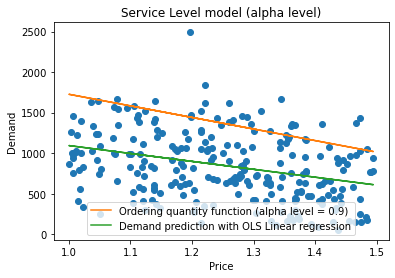

In [8]:
objSL, betaSL0, betaSL1 = SLModel(sampleSize = n, procurementCost = c, nonStockOut = alpha)
print("Objective:",objSL)
print('Estimation of a:', betaSL0)
print('Estimation of b:', betaSL1)

print('\nOrdering quantity - price function: q = ', round(betaSL0,0),'+', round(betaSL1,2),'* p')

#Plot
plt.plot(p,D,'o')
plt.plot(p, betaSL0 + betaSL1*p, label='Ordering quantity function (alpha level = ' +str(alpha)+')' )
plt.plot(p, coef1 + coef2*p, label = 'Demand prediction with OLS Linear regression')
plt.legend(loc = 8)
plt.xlabel('Price')
plt.ylabel('Demand')
plt.title('Service Level model (alpha level)')
plt.show()

## PRICE AND QUANTITY-SETTING NEWSVENDOR

**Reference:**   
DeYong, G. D. (2020). *The price-setting newsvendor: review and extensions.* International Journal of Production Research, 58(6), 1776-1804.   
Huber et. al. (2019). *A data-driven newsvendor problem: From data to decision.* European Journal of Operational Research, 278(3), 904-915.

 ### Basic approach

From the previous model, we obtain the ordering quantity function of price: *q = beta0 + beta1 * p*. It means that at a certain selling price p, we can calculate a corresponding ordering quantity q, which also represents the estimated demand level at that selling price. So if the relationship between demand and price is captured completely, the expected profit is:  
$\Pi(p)  = p*q(p) - c*q(p) = beta1*p^2 + (beta0 - beta1*c)*p - beta0*c$  
By taking the first-order derivative, we can find the optimal price p* as $\frac{1}{2*beta1}(-beta0 + beta1*c) $   (1)  and so, the optimal ordering quantity q*.   

Below is the optimization model of this approach (hereinafter called as "Basic approach"). The optimal price from this model is similar to the one calculated from equation (1).

To make the problem logical, the lower bound of price is procurement cost per unit (p >= c) to be profitable and the upper bound is -beta0/beta1 so that the expected demand is non-negative. Additionally, in case of beta1 greater than or equal to 0, the maximization problem is unbounded and the vendor will choose the price as high as possible (i.e. maximum value of price in historical data).   

In [9]:
#Price-setting 
def NV_Price(procurementCost, beta0, beta1, priceUpperBound):
    if beta1 >= 0:
        q = beta0 + beta1*priceUpperBound
        profit = priceUpperBound * q - procurementCost*q
        return profit, priceUpperBound, q
    else:
        pricingNV = gp.Model("Basic pricing NV model")

        #### Variables
        price = pricingNV.addVar(lb = procurementCost, ub = -beta0/beta1, vtype = GRB.CONTINUOUS)
        quantity = pricingNV.addVar()

        pricingNV.addConstr(quantity == beta0 + beta1*price)

        pricingNV.setObjective(price * quantity - procurementCost*quantity) #maximize expected profit
        pricingNV.modelSense = 0 #maximization

        pricingNV.Params.OutputFlag = 0 #not print output
        pricingNV.Params.NonConvex = 2 #enable Quadratic Optimization mode of Gurobi
        pricingNV.optimize()

        return pricingNV.objVal, price.x, quantity.x

Example with results from Cost model:

In [10]:
objVal, price, quantity = NV_Price(procurementCost = c, beta0 = betaC0, beta1 = betaC1, priceUpperBound = ubp)

print("Objective: ", objVal)
print('Optimal price from LP model:', price)
print('Optimal price from equation (1):', 0.5*(-betaC0+betaC1*c)/betaC1)

Objective:  808.2077676700592
Optimal price from LP model: 1.7274009980891323
Optimal price from equation (1): 1.7274009980891325


### Data-driven approach

However, another approach is proposed here to make the solution more data-driven and robust.  
Using estimation error calculated from historical demand and ordering quantity-price function, we can generate the distribution of estimated demand at a certain price and then solve a data-driven quantity-setting newsvendor problem with this given price. In detail, demands at certain price p have the form of d_i(p) = beta0 + beta1 * p + error_i with error_i is the estimation error in each observation. Therefore, with historical data set of size n (observations), we can generate n samples of demands at each price.


In [11]:
#Newsvendor with Price-setting
def DDNV_Price(sampleSize, procurementCost, beta0, beta1, priceUpperBound):
    if beta1 >= 0:
        q = beta0 + beta1*priceUpperBound
        profit = priceUpperBound * q - procurementCost*q
        return profit, priceUpperBound, q
    else:
        M = beta0*100 #big M, demand <= beta0
        error = np.array([(D[i] - beta0 - beta1*p[i])[0] for i in range(sampleSize)]) #estimation errors of all demand observations

        pricingNV = gp.Model("Data-driven pricing NV model")

        #### Variables
        price = pricingNV.addVar(lb = procurementCost, ub = -beta0/beta1, vtype = GRB.CONTINUOUS)
        quantity = pricingNV.addVar()

        sales = {}
        z = {}  # binary variable = 1 if beta0 + beta1*p + error > 0, = 0 otherwise 
                # ==> to ensure non-negativity: d_i(p) = max(0, beta0 + beta1*p + error_i)

        for t in range(sampleSize):
            sales[t] = pricingNV.addVar()
            z[t] = pricingNV.addVar(vtype = GRB.BINARY)

        for t in range(sampleSize):
            pricingNV.addConstr(M*z[t] >= beta0 + beta1*price + error[t] ) #if beta0 + beta1*p + error > 0, z must equal to 1
            pricingNV.addConstr(sales[t] <= 0 + M*z[t] ) #if z = 0 (i.e. beta0 + beta1*p + error <= 0), sales = 0; otherwise, unbounded
            pricingNV.addConstr(sales[t] <= beta0 + beta1*price + error[t] + M*(1-z[t]) ) #if z = 1, sales <= beta0 + beta1*p + error: otherwise, unbounded
            pricingNV.addConstr(sales[t] <= quantity)

        pricingNV.setObjective( sum(price * sales[t] for t in range(sampleSize)) / sampleSize - procurementCost*quantity) #maximize expected profit
        pricingNV.modelSense = 0 #maximization

        pricingNV.Params.OutputFlag = 0

        pricingNV.Params.NonConvex = 2 #enable Quadratic Optimization mode of Gurobi
        pricingNV.optimize()
        
        #if pricingNV.Status != 2: return 0,0,0

        return pricingNV.objVal, price.x, quantity.x

Example run with results from Cost model

In [12]:
objValDD, priceDD, quantityDD = DDNV_Price(sampleSize = n, procurementCost = c, beta0 = betaC0, beta1 = betaC1, priceUpperBound = ubp)

print("Objective: ", objValDD)
print('Optimal price:', priceDD)
print('Optima ordering quantity:', quantityDD)

Objective:  492.48010501519946
Optimal price: 1.6034773125938035
Optima ordering quantity: 858.3559492650359


In [13]:
# function to combine two steps into 1 flow

In [14]:
def DDNV_main(sampleSize, procurementCost, priceUpperBound, estimationModel = 'cost', nonStockOut = None):

    if estimationModel == 'service' and nonStockOut is not None:
        (estObjVal, estBeta0, estBeta1) = SLModel(sampleSize, procurementCost, nonStockOut)
    else:                
        (estObjVal, estBeta0, estBeta1) = costModel(sampleSize, procurementCost)
    print('\nOrdering quantity parameters:', estBeta0, estBeta1)

    (optV, optP, optQ) = NV_Price(procurementCost, estBeta0, estBeta1, priceUpperBound)
    print('Basic approach:', optV, optP, optQ)

    (optVDD, optPDD, optQDD) = DDNV_Price(sampleSize, procurementCost, estBeta0, estBeta1, priceUpperBound)
    print('Data-driven approach:', optVDD, optPDD, optQDD,'\n')

        
    return optV, optP, optQ, optVDD, optPDD, optQDD


In [15]:
DDNV_main(sampleSize = n, procurementCost = c, priceUpperBound = ubp, estimationModel = 'cost', nonStockOut = None)


Ordering quantity parameters: 1585.179545198668 -536.4757256997037
Basic approach: 808.2077676700592 1.7274009980891323 658.4708411744082
Data-driven approach: 492.48010501519946 1.6034773125938035 858.3559492650359 



(808.2077676700592,
 1.7274009980891323,
 658.4708411744082,
 492.48010501519946,
 1.6034773125938035,
 858.3559492650359)

# ANALYSIS

## Sensitivity analysis

To generate out-of-sample demand observations, we will randomly draw 100,000 error terms and demands in the same way as we did previously (i.e. u ~ N(0,sigma) and D = a - b * p + u).This out-of-sample set will be used to evaluate the performance of the solution, which will be done for a significant number of times to obtain the average performance.

In [16]:
def outOfSampleError(testSize):
    testU = np.random.normal(loc = 0, scale = sigma, size =(testSize,) )
    return testU

In [17]:
def outOfSampleDemand(testU, chosenPrice):
    testD = a - b*chosenPrice + testU
    for i in range(len(testD)):
        if testD[i]<=0: testD[i] = 0
            
    return testD

In [18]:
def testEvaluation(testD, chosenPrice, chosenQty, procurementCost):
    return sum( [chosenPrice * min(testD[i], chosenQty) for i in range(len(testD))] ) / len(testD) - procurementCost*chosenQty   
    

### 1. Sample size's effect       

Here we want to learn about the effect of sample size on performance of solution. To do so, from the same demand sampling set, we take subsets with different sizes and solve the problem with these subsets. The solutions are evaluated by generating out-of-sample demand based on each chosen price solution with same error terms. Then this test is done for multiple times to get the average objective value (i.e. expected profit).

In [19]:
import copy

testRep = 10

# Run the model with different sample sizes: 100, 200, 500 and 700
sampleSizeSet = [50, 100, 200, 500, 700]
resultSize = pd.DataFrame(index = range(len(sampleSizeSet)), columns = ['Sample size', 'Avg. out-of-sample profit'])
optValOutSample = np.zeros(shape=(len(sampleSizeSet),testRep))

for j in range(testRep):
    print('Test run = ', j)
    samplingDemand(sampleSize=max(sampleSizeSet), coefVar=cv)
    demandPool = copy.deepcopy(D)
    pricePool = copy.deepcopy(p)
    errorPool = copy.deepcopy(u)
    
    testU = outOfSampleError(testSize = 100000)
    
    for i in range(len(sampleSizeSet)):
        print('Considering n =', sampleSizeSet[i])
        D = demandPool[0:sampleSizeSet[i]]
        p = pricePool[0:sampleSizeSet[i]]
        
        optV, optP, optQ, optVDD, optPDD, optQDD = DDNV_main(sampleSize=sampleSizeSet[i], procurementCost=c, 
                                                             estimationModel = 'cost', nonStockOut = None, priceUpperBound=ubp)
        
        testD = outOfSampleDemand(testU, chosenPrice = optPDD)
        testV = testEvaluation(testD, chosenPrice = optPDD, chosenQty = optQDD, procurementCost = c)
        
        optValOutSample[i,j] = testV
        
for i in range(len(sampleSizeSet)):
    resultSize.iloc[i,:] = [sampleSizeSet[i], np.mean(optValOutSample[i,:])]

Test run =  0
Considering n = 50

Ordering quantity parameters: 1728.4683484726186 -923.866359868143
Basic approach: 434.0755878842448 1.185453667086282 633.2675842692736
Data-driven approach: 270.63184494588893 1.0813338657278837 619.9045902949923 

Considering n = 100

Ordering quantity parameters: 1420.4776610418924 -667.818169122664
Basic approach: 441.973326716323 1.3135212747416136 543.2842882402803
Data-driven approach: 290.3054070983567 1.2240107270936613 603.0645571179921 

Considering n = 200

Ordering quantity parameters: 1333.407087468352 -593.0074914449543
Basic approach: 453.26937502254333 1.3742750780595536 518.4516708729374
Data-driven approach: 298.3560415030055 1.2814547850615206 581.1999169166832 

Considering n = 500

Ordering quantity parameters: 1458.8614597462933 -694.8903164370797
Basic approach: 444.40329865119014 1.2997062811483207 555.7081507638767
Data-driven approach: 289.34270642589155 1.2123684982642684 610.2315205659116 

Considering n = 700

Ordering qu

Data-driven approach: 508.90544755253245 1.4127804990184898 866.1394769253691 

Considering n = 100

Ordering quantity parameters: 1540.0268185220189 -497.6241747600803
Basic approach: 837.5977125316898 1.7973794247079258 645.6073655709895
Data-driven approach: 474.0047182271561 1.665363391101942 817.9720640835369 

Considering n = 200

Ordering quantity parameters: 1645.976074054889 -568.99941858103
Basic approach: 814.4199410759347 1.6963776414390912 680.738182382187
Data-driven approach: 499.77813991589744 1.5615382145803824 818.332633255776 

Considering n = 500

Ordering quantity parameters: 1290.3343340731572 -263.9291658742681
Basic approach: 1271.0043582168507 2.6944709052879983 579.1848755680115
Data-driven approach: 844.6023654433534 2.586114795264683 849.7455336990618 

Considering n = 700

Ordering quantity parameters: 1292.038808319984 -264.01937665577606
Basic approach: 1274.212878117744 2.6968636065384737 580.014559996048
Data-driven approach: 842.1336611363743 2.5926685

Data-driven approach: 395.6998208428675 1.1304280227587662 833.1803987127257 

Considering n = 100

Ordering quantity parameters: 1972.6243133264427 -1022.4675987915579
Basic approach: 522.183352492207 1.2146390338715198 730.6952569653322
Data-driven approach: 365.3691379511819 1.14856043328908 791.2928152847314 

Considering n = 200

Ordering quantity parameters: 1589.9514657259804 -744.6899119757487
Basic approach: 497.71239972326 1.3175258521413662 608.803254869053
Data-driven approach: 321.12080923893257 1.2302344592864751 673.797774711462 

Considering n = 500

Ordering quantity parameters: 1596.3379803231794 -732.4528753321259
Basic approach: 516.4750041742043 1.3397206046186458 615.0557713285581
Data-driven approach: 333.1215004992844 1.2482683347631507 683.7447402213371 

Considering n = 700

Ordering quantity parameters: 1478.8251028085115 -645.4136717255386
Basic approach: 517.7336279506401 1.3956412899147417 578.0591334728712
Data-driven approach: 334.39600377896085 1.297890

In [20]:
resultSize

,Sample size,Avg. out-of-sample profit
0,50,184.724
1,100,138.054
2,200,255.676
3,500,222.325
4,700,258.316


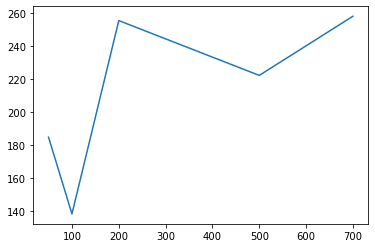

In [21]:
plt.plot(resultSize['Sample size'].to_list(), resultSize['Avg. out-of-sample profit'].to_list())

**Comment:** As expected, the more historical data we have, the higher the out-of-sample profit is, which means better solution we have. With more data, the relationship between demand and price is capture more correctly and so the estimated demand is nearer to the true demand. 

### 2. Procurement cost's effect       

Here we want to learn about the influence of procurement cost (c) on the optimal price and ordering quantity. To do so, for a certain sampling set, we run the model with different procurement costs from 0.1 to 0.9 (since c < p). Then this test is done for multiple times to get the average optimal price and ordering quantity over all test instances.

In [26]:
testRep = 50
costSet = [0.1*(i+1) for i in range(9)]
resultCost = pd.DataFrame(index = range(len(costSet)), columns = ['Procurement cost', 
                                                                  'Avg. opt. price (Basic)', 'Avg. opt. price (DD)',
                                                                  'Avg. opt. order qty (Basic)', 'Avg. opt. order qty (DD)' ])
#book-keeping variables
optPrice = np.zeros(shape=(len(costSet),testRep))
optQty = np.zeros(shape=(len(costSet),testRep))
optPriceDD = np.zeros(shape=(len(costSet),testRep))
optQtyDD = np.zeros(shape=(len(costSet),testRep))

for j in range(testRep):
    print('Test run = ', j)
    # in each test run, draw a sampling set 
    samplingDemand(sampleSize=n, coefVar=cv)
    
    for i in range(len(costSet)):
        print('Considering c =', costSet[i])
        optV, optP, optQ, optVDD, optPDD, optQDD = DDNV_main(sampleSize=n, procurementCost=costSet[i], 
                                                             estimationModel = 'cost', nonStockOut = None, priceUpperBound = ubp)
        #save result of each test instance
        optPrice[i,j] = optP
        optQty[i,j] = optQ
        optPriceDD[i,j] = optPDD
        optQtyDD[i,j] = optQDD    

#take the average of all test instances
for i in range(len(costSet)):
    resultCost.iloc[i,:] = [costSet[i], np.mean(optPrice[i,:]), np.mean(optPriceDD[i,:]), 
                            np.mean(optQty[i,:]), np.mean(optQtyDD[i,:])]

Test run =  0
Considering c = 0.1

Ordering quantity parameters: 1788.5985269363377 -524.7560035849541
Basic approach: 1435.9639506731473 1.7542192130411487 868.0614632889212
Data-driven approach: 749.7897648414013 1.3423850180010086 1091.3919106892629 

Considering c = 0.2

Ordering quantity parameters: 1559.1911571794176 -427.9061229711939
Basic approach: 1268.6931296609885 1.9218846067836943 736.8049662925895
Data-driven approach: 670.6140790962143 1.544582627607533 925.6490173475822 

Considering c = 0.30000000000000004

Ordering quantity parameters: 1504.2404795069222 -454.21689669188703
Basic approach: 1029.9907034283533 1.805861429267026 683.9877052496779
Data-driven approach: 571.6705134809168 1.538308878361997 851.6151979548509 

Considering c = 0.4

Ordering quantity parameters: 1272.2334744834384 -329.68088714794504
Basic approach: 986.1228947791024 2.1294923122317986 570.1805598121302
Data-driven approach: 561.7325070483272 1.8956850026439414 767.0484947825576 

Considering

Data-driven approach: 513.3482709736342 2.11954518146506 759.2422567373278 

Considering c = 0.8

Ordering quantity parameters: 1023.2430532522711 -223.86137159062486
Basic approach: 795.8004281098363 2.6854390777241264 422.07697798988556
Data-driven approach: 798.5631341214113 3.2332558944586927 771.4624108903672 

Considering c = 0.9

Ordering quantity parameters: 444.1183979651249 141.76568373286565
Basic approach: 394.06015413865407 1.5 656.7669235644235
Data-driven approach: 394.06015413865407 1.5 656.7669235644235 

Test run =  4
Considering c = 0.1

Ordering quantity parameters: 1962.7402616760298 -813.943926188762
Basic approach: 1087.1333285794365 1.2556974679241293 940.6729345285769
Data-driven approach: 650.8237502505859 1.013278240991108 1105.4546712005954 

Considering c = 0.2

Ordering quantity parameters: 1395.7037201743694 -471.3679376575698
Basic approach: 898.3005921911162 1.5804822397448393 650.7150663214277
Data-driven approach: 519.3142907774669 1.3007719037178227 

Data-driven approach: 631.1355948197885 1.7301974185653117 991.5810811645769 

Considering c = 0.6000000000000001

Ordering quantity parameters: 1548.4720993126007 -418.19359792692813
Basic approach: 1006.5023874226702 2.151381880292639 648.7779702782221
Data-driven approach: 656.5859026373137 2.1525433097129536 906.2604530247993 

Considering c = 0.7000000000000001

Ordering quantity parameters: 1183.4864992955395 -223.51542037249925
Basic approach: 1179.7640147650245 2.9974381439168765 513.5128525173949
Data-driven approach: 1038.0871578467315 3.443057528342239 926.2203412890676 

Considering c = 0.8

Ordering quantity parameters: 1012.3512116900303 -182.82522597895442
Basic approach: 1025.7250740437585 3.1686310963634887 433.04551545343355
Data-driven approach: 1186.3382769376824 4.076622454853468 920.0710914203679 

Considering c = 0.9

Ordering quantity parameters: 540.007701996293 100.00287757152178
Basic approach: 414.0072110121455 1.5 690.0120183535757
Data-driven approach: 414

Data-driven approach: 373.6581191284809 1.1127551415239176 661.6253354223094 

Considering c = 0.4

Ordering quantity parameters: 1337.9943352383925 -640.1205307461333
Basic approach: 457.1824198406391 1.245111249344563 540.9730614699696
Data-driven approach: 311.7280602639482 1.1483531164401501 595.5770583002375 

Considering c = 0.5

Ordering quantity parameters: 1218.0117744400086 -570.7261528101807
Basic approach: 381.0205602386019 1.3170719822831651 466.3243490174591
Data-driven approach: 252.25734541117043 1.227764895036383 517.2007897449112 

Considering c = 0.6000000000000001

Ordering quantity parameters: 1184.0790778037351 -574.6713238816154
Basic approach: 306.42936698383176 1.3302228670519676 419.638141737383
Data-driven approach: 203.29368075735275 1.2637324245202426 465.51235675253844 

Considering c = 0.7000000000000001

Ordering quantity parameters: 1177.8431879396585 -601.9397469037817
Basic approach: 237.6774878900644 1.3283729966314497 378.24268255350563
Data-driven 

Data-driven approach: 738.8726223698895 1.5033993407893615 1016.964395141928 

Considering c = 0.30000000000000004

Ordering quantity parameters: 1905.7109524036773 -693.4239967864872
Basic approach: 1039.0937362296777 1.5241310952860392 848.8418766838657
Data-driven approach: 607.0281919416927 1.3054916335623503 1007.1943473984674 

Considering c = 0.4

Ordering quantity parameters: 1773.4802626861642 -674.0819391322988
Basic approach: 838.7545834440243 1.5154782525170816 751.9237435166225
Data-driven approach: 512.2708897913084 1.3615027612011474 916.0537540030576 

Considering c = 0.5

Ordering quantity parameters: 1717.0147618924161 -675.785069238961
Basic approach: 703.6179860780976 1.5203852452866717 689.5611136364678
Data-driven approach: 427.54713228793344 1.3879665357993574 802.8875034625735 

Considering c = 0.6000000000000001

Ordering quantity parameters: 1634.2093879099123 -691.1488400963018
Basic approach: 537.9554839126564 1.4822412866107162 609.7600419260657
Data-driven

Data-driven approach: 554.3218502454595 0.9453854585070794 932.5207951516754 

Considering c = 0.2

Ordering quantity parameters: 1777.8174983160593 -917.5092244061868
Basic approach: 692.5931465245995 1.0688281332902483 797.1578267174111
Data-driven approach: 492.06726901517305 0.9597193201451001 874.624922857998 

Considering c = 0.30000000000000004

Ordering quantity parameters: 1711.5212247797876 -894.0255092905098
Basic approach: 582.5208692175097 1.1071993231703392 721.6567859963174
Data-driven approach: 404.46541426359954 1.0066470215466998 779.3090424665529 

Considering c = 0.4

Ordering quantity parameters: 1544.0294049542617 -802.8982361057659
Basic approach: 465.62915446065665 1.161534934018006 611.4350552559775
Data-driven approach: 319.4594983733972 1.0752944565365137 657.375589969105 

Considering c = 0.5

Ordering quantity parameters: 1419.4685748227282 -733.5129098470501
Basic approach: 377.7039205805367 1.2175825440609571 526.3560599496014
Data-driven approach: 251.39

Data-driven approach: 30105.856204613134 83.0443506638246 1189.2892993790763 

Test run =  23
Considering c = 0.1

Ordering quantity parameters: 2347.175650955368 -960.744939096549
Basic approach: 1318.6268834311547 1.271539430206403 1125.5505785228568
Data-driven approach: 765.6957604859954 1.0227772635009165 1335.3809686574273 

Considering c = 0.2

Ordering quantity parameters: 1810.4001446301563 -656.5562975960496
Basic approach: 1073.5330292413619 1.4787089936223687 839.5444425554732
Data-driven approach: 611.8605586917209 1.2169691850725024 1011.3913621904861 

Considering c = 0.30000000000000004

Ordering quantity parameters: 1693.134493054474 -641.2066645956966
Basic approach: 878.1560618969628 1.470272064017032 750.3862468378826
Data-driven approach: 517.3624725996856 1.2658110812531522 882.0220018987079 

Considering c = 0.4

Ordering quantity parameters: 1649.7646496948846 -664.1131042775677
Basic approach: 721.1823269327015 1.4420810845838705 692.0597039919288
Data-driven a

Data-driven approach: 420.4977607315146 2.006016110644216 671.8209931722737 

Considering c = 0.8

Ordering quantity parameters: 1086.0228162761346 -328.1225864958789
Basic approach: 516.7222838077616 2.0549040830655745 411.7623735397158
Data-driven approach: 420.225963235092 2.334847555473135 622.6608822760461 

Considering c = 0.9

Ordering quantity parameters: 647.7505379892357 -73.92493980131403
Basic approach: 1142.4238950055483 4.831136729567698 290.6090460840265
Data-driven approach: 2016.9221601081401 7.397700615521172 806.2951987123956 

Test run =  27
Considering c = 0.1

Ordering quantity parameters: 1548.2033630761434 -506.0349934409051
Basic approach: 1108.0287830490615 1.5797394282446426 748.7999318660266
Data-driven approach: 572.1002596683426 1.204631886566169 938.6174742589288 

Considering c = 0.2

Ordering quantity parameters: 1649.8026641802714 -675.4703306569262
Basic approach: 849.1646608563357 1.321225114784658 757.3542990244432
Data-driven approach: 496.49244313

Data-driven approach: 454.6073367419403 1.6307366266754741 763.5097040465876 

Considering c = 0.6000000000000001

Ordering quantity parameters: 1472.5803581905473 -544.1917295030398
Basic approach: 603.4020950788739 1.6529977380723144 573.0326602443618
Data-driven approach: 364.47634932426064 1.585192655858743 700.407122872687 

Considering c = 0.7000000000000001

Ordering quantity parameters: 964.694279848427 -233.58781798260472
Basic approach: 686.9941850925028 2.4149498937488847 400.5914036303019
Data-driven approach: 580.6885591083411 2.70177843482419 651.9630630650864 

Considering c = 0.8

Ordering quantity parameters: 769.838423116973 -137.6788055237184
Basic approach: 790.2414446073226 3.1957768088870817 329.8476893489992
Data-driven approach: 913.2692443443849 4.0300468588238205 686.2844228651816 

Considering c = 0.9

Ordering quantity parameters: 613.2967786411418 -62.43440113125453
Basic approach: 1242.771959071601 5.361529281363817 278.5529088115064
Data-driven approach: 

Data-driven approach: 418.039748212152 1.2025834491767604 816.6098569524958 

Considering c = 0.5

Ordering quantity parameters: 1549.1703771715024 -656.2055648716845
Basic approach: 568.0407751514132 1.430400213060087 610.5337973678302
Data-driven approach: 340.8911816302539 1.3122772202614177 706.0600437851617 

Considering c = 0.6000000000000001

Ordering quantity parameters: 1523.9110868197831 -686.8484688345746
Basic approach: 449.91863400872904 1.4093502831894733 555.9010027595192
Data-driven approach: 272.31795820491425 1.3230307828420884 632.9582424043676 

Considering c = 0.7000000000000001

Ordering quantity parameters: 1439.4928162708998 -681.6568863460304
Basic approach: 339.6447734228895 1.4058778507961616 481.1664979143393
Data-driven approach: 212.71582653842466 1.3676255837270106 563.905914350181 

Considering c = 0.8

Ordering quantity parameters: 1117.6603740138967 -490.86773948405084
Basic approach: 267.6769745627968 1.5384536852927684 362.48309121332807
Data-driven 

Data-driven approach: 546.5314189399373 0.9490190644572759 993.045238562986 

Considering c = 0.30000000000000004

Ordering quantity parameters: 1579.5282305717371 -746.2739583129517
Basic approach: 615.6506513597118 1.208276396340068 677.8230215389258
Data-driven approach: 408.0215338169379 1.0842530639761279 750.7595267036049 

Considering c = 0.4

Ordering quantity parameters: 1570.4973343533748 -767.5477267541928
Basic approach: 519.9602632307771 1.2230616804734062 631.7391218258489
Data-driven approach: 337.69814535684776 1.1196725563580376 698.8786762026848 

Considering c = 0.5

Ordering quantity parameters: 1526.4345872803055 -778.4849931234932
Basic approach: 415.29569054509136 1.2303879334628118 568.5960453592795
Data-driven approach: 273.06279419937863 1.1486876818745164 613.7042959348842 

Considering c = 0.6000000000000001

Ordering quantity parameters: 1346.6926054991004 -673.7633367812389
Basic approach: 329.5604455067411 1.2993810378081998 471.21730171517845
Data-driven

Data-driven approach: 180.6801311250016 1.9108680407093441 367.91698213669247 

Test run =  42
Considering c = 0.1

Ordering quantity parameters: 2808.0771549996903 -647.0975337100832
Basic approach: 2907.6237770405332 2.2197479967971745 1371.6837008143407
Data-driven approach: 1449.9097591128036 1.6613345099842645 1806.6332987812814 

Considering c = 0.2

Ordering quantity parameters: 2840.766122562287 -857.3602129729651
Basic approach: 2077.6363241313757 1.7566934641810021 1334.6470399838472
Data-driven approach: 1193.9936963446046 1.4489360716384168 1663.236414106139 

Considering c = 0.30000000000000004

Ordering quantity parameters: 2457.4308178671254 -643.1104728037411
Basic approach: 1993.4171272204085 2.060582179725335 1132.2488380130017
Data-driven approach: 1131.3094944736092 1.7566890208052979 1436.1740817216228 

Considering c = 0.4

Ordering quantity parameters: 2386.51562129438 -687.0840073046453
Basic approach: 1622.509365416174 1.93669856663992 1055.841009186261
Data-dr

Data-driven approach: 582.9738470165961 2.6745317426941213 641.4966480259204 

Considering c = 0.8

Ordering quantity parameters: 825.1514970894445 -169.88878472238312
Basic approach: 699.0638394892826 2.8285049140760896 344.6202346557691
Data-driven approach: 722.8968868924305 3.3845558395088697 632.9249827906299 

Considering c = 0.9

Ordering quantity parameters: 668.719780764465 -99.13925516394556
Basic approach: 846.8235370539187 3.8226286305995036 289.747225558457
Data-driven approach: 1229.9219684736083 5.308550859302408 698.5156246522353 

Test run =  46
Considering c = 0.1

Ordering quantity parameters: 1484.4720059494502 -730.1265134871055
Basic approach: 682.1480499917226 1.0665854674004154 705.7296773003701
Data-driven approach: 456.0295227965307 0.90886179197819 808.7050086549461 

Considering c = 0.2

Ordering quantity parameters: 1404.2840372141554 -711.2732917982532
Basic approach: 559.8123012130646 1.0871620749767086 631.0146894272525
Data-driven approach: 376.28364025

Data-driven approach: 216.19675718909207 1.1003915910166733 514.2044453096734 

Considering c = 0.6000000000000001

Ordering quantity parameters: 1253.570630980431 -691.3087467402971
Basic approach: 254.43078868341772 1.2066648128577473 419.3926914681262
Data-driven approach: 166.20295757614298 1.1485246197984031 450.6625580594216 

Considering c = 0.7000000000000001

Ordering quantity parameters: 1203.6952748259812 -682.3954435846955
Basic approach: 193.10753591782668 1.2319631535806004 363.0092321583473
Data-driven approach: 124.22227289962684 1.184117748166324 381.42946200481583 

Considering c = 0.8

Ordering quantity parameters: 1136.698481490498 -663.1766315270579
Basic approach: 138.5100533081873 1.2570103555014362 303.0785881344258
Data-driven approach: 88.54959408628486 1.226719318829074 323.1661554795805 

Considering c = 0.9

Ordering quantity parameters: 1044.7973791452139 -624.2616086596846
Basic approach: 93.41124934607575 1.2868265520832178 241.48096567574876
Data-driven

In [27]:
resultCost

,Procurement cost,Avg. opt. price (Basic),Avg. opt. price (DD),Avg. opt. order qty (Basic),Avg. opt. order qty (DD)
0,0.1,1.52007,1.19019,990.126,1204.52
1,0.2,1.47051,1.22811,862.146,1020.66
2,0.3,1.53605,1.33424,753.892,891.082
3,0.4,1.52333,1.37464,671.019,793.23
4,0.5,1.57269,1.46354,593.211,704.276
5,0.6,1.64056,1.59082,514.373,629.007
6,0.7,1.86045,1.92675,431.253,567.811
7,0.8,2.19638,2.5259,358.457,534.729
8,0.9,3.30219,4.85938,314.509,526.564


**Comment:** In general, when the procurement cost increases, the optimal price also increases to cover up the increase in cost, leading to the decrease in optimal ordering quantity. This trend can be seen in both approaches: basic and data-driven.

## Basic approach vs Data-driven approach in Price and Quantity-setting Newsvendor

Here we want to compare the performance of Basic approach with Data-driven approach to solve the Price and Quantity-setting Newsvendor. In basic approach, the vendor takes the optimal price as given from the ordering quantity function, while in Data-driven approach, the vendor use the historical data to make the solution more robust.

For a certain sampling set, we runs both approaches to obtain the solution of optimal price and ordering quantity. Two solutions are evaluated with the same out-of-sample demand set to get the profit of each solution when dealing with unknown demand. Then this test is done for multiple times to get the average performance of each solution. In addition, we will run the experiment with different sample sizes and different coefficients of variation.

In [51]:
testRep = 50
results = pd.DataFrame(index = range(9), columns = ["Sample size", 'cv', 'Avg Out-of-sample profit (Basic)', 
                                                    'Avg Out-of-sample profit (DD)'])
idx=0
for i in [100,200,500]: #run experiment with different sampling sizes
    for k in [0.3, 0.5, 0.8]: #run experiment with different coefficient of variation
        print(i, k)
        
        resultDD = pd.DataFrame(index = range(testRep), columns = ['Out-of-sample profit (Basic)', 
                                                                   'Out-of-sample profit (Data-driven)'])

        for j in range(testRep):
            print('Test run = ', j)
            #random generate demands
            samplingDemand(sampleSize=i, coefVar=k)
            testU = outOfSampleError(testSize = 100000)

            optV, optP, optQ, optVDD, optPDD, optQDD = DDNV_main(sampleSize=i, procurementCost=c, 
                                                                 estimationModel = 'cost', nonStockOut = None, priceUpperBound = ubp)

            #Basic approach
            testD = outOfSampleDemand(testU, chosenPrice = optP)
            testV = testEvaluation(testD, chosenPrice = optP, chosenQty = optQ, procurementCost = c)

            #Data-driven approach
            testDDD = outOfSampleDemand(testU, chosenPrice = optPDD)
            testVDD = testEvaluation(testDDD, chosenPrice = optPDD, chosenQty = optQDD, procurementCost = c)

            #save result in each run
            resultDD.iloc[j,:] = [testV, testVDD]

        print(resultDD)
        print('\n\nOut-of-sample profit from Basic approach')
        print('Average:', np.mean(resultDD.iloc[:,0]) )
        print('Out-of-sample profit from Data-driven approach')
        print('Average:', np.mean(resultDD.iloc[:,1]) )
        
        results.iloc[idx,:] = [i, k, np.mean(resultDD.iloc[:,0]), np.mean(resultDD.iloc[:,1])]
        idx+=1
        
print(results)

100 0.3
Test run =  0

Ordering quantity parameters: 1663.4151570759036 -778.1540133329046
Basic approach: 521.7276058994762 1.3188212928128102 637.1690752047257
Data-driven approach: 395.0217830721222 1.257134671223065 685.1707673637436 

Test run =  1

Ordering quantity parameters: 1373.6607209666063 -497.6118914739292
Basic approach: 635.6853036656275 1.6302531094040134 562.4273876148208
Data-driven approach: 470.7296688494316 1.5415328802123631 660.1818114012583 

Test run =  2

Ordering quantity parameters: 1823.242265941037 -921.7644223258515
Basic approach: 503.38917241234606 1.2389957899115496 681.1800273890556
Data-driven approach: 398.0957791254881 1.1936560001312462 722.9726325242866 

Test run =  3

Ordering quantity parameters: 1811.8756096076715 -705.5633753267758
Basic approach: 754.3457992234729 1.5339921068525675 729.546960972142
Data-driven approach: 548.3147775385421 1.4471383916466185 832.0955890450438 

Test run =  4

Ordering quantity parameters: 1769.786375945238

Data-driven approach: 328.0877405727306 1.3217050541485986 539.6630356616259 

Test run =  36

Ordering quantity parameters: 1375.6324293628536 -762.8720801059073
Basic approach: 323.916186701846 1.1516140878899899 497.09819465495013
Data-driven approach: 256.6850664604443 1.1065876376872528 511.73123677004924 

Test run =  37

Ordering quantity parameters: 1509.4644410940573 -583.3184472471601
Basic approach: 635.6088834054685 1.5438596818064254 608.9026087352386
Data-driven approach: 468.194472444423 1.4582717109383794 685.6052899318574 

Test run =  38

Ordering quantity parameters: 1860.6658332085924 -882.6095243586567
Basic approach: 570.6333872323742 1.3040707877363067 709.6805355146321
Data-driven approach: 425.12074955800483 1.2393132264398778 766.8361758891008 

Test run =  39

Ordering quantity parameters: 1438.241321790996 -680.1670158205711
Basic approach: 443.25531675935906 1.3072707058249982 549.0789069403552
Data-driven approach: 353.5538696325638 1.2540691154526578 586.

Data-driven approach: 356.168752373373 1.436599228278511 670.8728536670434 

Test run =  6

Ordering quantity parameters: 1949.687827180011 -840.4083335276563
Basic approach: 695.8879910378419 1.4099645966122791 764.7418302080914
Data-driven approach: 476.4586599204756 1.3301674739790217 871.16010067326 

Test run =  7

Ordering quantity parameters: 1839.023135934496 -1022.3052943216187
Basic approach: 431.19214112211955 1.1494490912593944 663.9352443868436
Data-driven approach: 285.2926697967661 1.0769871606594916 699.4778893495563 

Test run =  8

Ordering quantity parameters: 1809.0279494724068 -541.4288905768701
Basic approach: 1092.6681593558205 1.9206053010442075 769.156752091986
Data-driven approach: 673.7250555016944 1.7899769804679224 1047.750024391881 

Test run =  9

Ordering quantity parameters: 1415.231398093719 -560.4547024826868
Basic approach: 574.6379594393113 1.512574291753255 567.5020234261879
Data-driven approach: 342.4825489331465 1.3851500991968164 667.87962447510

Data-driven approach: 265.62488004661816 1.3325838704984625 456.3196458836861 

Test run =  42

Ordering quantity parameters: 1758.2787652028105 -497.006860116573
Basic approach: 1146.57449701807 2.0188677021383628 754.8876675722621
Data-driven approach: 810.3415550408188 1.9851871235678102 1074.7428820788155 

Test run =  43

Ordering quantity parameters: 1830.454064460163 -961.4967953346361
Basic approach: 473.6639258216918 1.2018773610800741 674.8528333964223
Data-driven approach: 302.7705402996131 1.1132353458987307 707.7591949193219 

Test run =  44

Ordering quantity parameters: 858.6940913411937 -337.00580055804636
Basic approach: 353.3795853298435 1.5240049131488034 345.0955955310853
Data-driven approach: 228.61989140775182 1.4147131053371889 401.2016656565899 

Test run =  45

Ordering quantity parameters: 1750.6674634292096 -556.0377892653896
Basic approach: 975.0658359225894 1.8242342492064318 736.3242843982573
Data-driven approach: 562.8710118155524 1.685300271121379 907.69

Data-driven approach: 214.53170728613424 1.1084357025004716 598.0528560688667 

Test run =  12

Ordering quantity parameters: 1346.197764515637 -353.29774027055504
Basic approach: 967.9120897425121 2.1551887559268286 584.7744471901796
Data-driven approach: 643.0772050348014 2.147097765800413 887.5003405712256 

Test run =  13

Ordering quantity parameters: 2398.192076623573 -711.5250628078797
Basic approach: 1465.6962436165227 1.9352477881521326 1021.2147726098167
Data-driven approach: 767.4366965265957 1.8372566681311993 1440.43416772945 

Test run =  14

Ordering quantity parameters: 1456.7637742361326 -438.1268802229093
Basic approach: 874.1201386188297 1.9124907532436302 618.8501670623391
Data-driven approach: 505.9273609929404 1.9963843774712917 940.1230528086847 

Test run =  15

Ordering quantity parameters: 1427.7460571242348 -231.49046478937584
Basic approach: 1858.9817140602283 3.3338118071586345 656.0004123647735
Data-driven approach: 1144.6473958969873 3.4449488813946028 11

Ordering quantity parameters: 1279.2629072278035 -625.7337363656978
Basic approach: 373.13047467524007 1.2722102732208795 483.1980195224773
Data-driven approach: 212.54638418798342 1.1656699318029125 544.7187393089815 

Test run =  48

Ordering quantity parameters: 1875.355899606131 -806.5312329386609
Basic approach: 671.7191204765769 1.4126058750218031 736.0451415684004
Data-driven approach: 345.1757381865373 1.2738659151770284 847.9432524398684 

Test run =  49

Ordering quantity parameters: 1674.6656720568744 -687.1010071150849
Basic approach: 644.689635679805 1.4686459157498941 665.557584249666
Data-driven approach: 352.09319782663636 1.3259330976182122 776.9994228337475 

   Out-of-sample profit (Basic) Out-of-sample profit (Data-driven)
0                       392.425                            385.464
1                       474.618                            497.281
2                        457.64                            451.341
3                       103.325               

Data-driven approach: 239.7398191150583 1.036570026435672 509.80406282300555 

Test run =  17

Ordering quantity parameters: 1671.3675508307988 -897.9255600133582
Basic approach: 416.034883702202 1.1806826897799492 611.2023854120598
Data-driven approach: 322.89447214816033 1.1319182702107016 643.6296301725512 

Test run =  18

Ordering quantity parameters: 1637.4534435205485 -511.10853351882184
Basic approach: 934.0703634831731 1.8518647079194654 690.9495883805691
Data-driven approach: 682.838338886321 1.756942906010333 846.3020610316653 

Test run =  19

Ordering quantity parameters: 1761.2079936256926 -790.3794024103273
Basic approach: 590.2247608986767 1.3641535244053318 683.0091462102646
Data-driven approach: 444.031528463981 1.2960380771988436 738.853732746262 

Test run =  20

Ordering quantity parameters: 1414.8818754914116 -697.8589863645435
Basic approach: 407.05017186558825 1.263730497949276 532.97619115457
Data-driven approach: 307.1741952892733 1.2051220038216488 573.280898

Data-driven approach: 267.21794143784234 1.1559792962125666 588.4403068702832 

Test run =  1

Ordering quantity parameters: 1868.3429306192231 -637.3475336331477
Basic approach: 941.9799993385839 1.715717549708623 774.8345819013248
Data-driven approach: 625.6197614510432 1.6221353509961045 1000.0122249851519 

Test run =  2

Ordering quantity parameters: 1718.076129191479 -706.1514088427865
Basic approach: 659.6411677050594 1.4665069046643942 682.5002123850429
Data-driven approach: 429.5855686100523 1.3671932255391586 789.4254497913629 

Test run =  3

Ordering quantity parameters: 1153.206191089828 -347.8048410117188
Basic approach: 689.3491421009755 1.907835163730473 489.65188529198434
Data-driven approach: 407.31333617844166 1.78694529467146 646.1707366514712 

Test run =  4

Ordering quantity parameters: 1879.3384321699195 -732.0402659547614
Basic approach: 782.105978721027 1.5336305047501708 756.6591495962693
Data-driven approach: 472.3076934821603 1.4133124805548922 901.82814639


Ordering quantity parameters: 1046.3945607915086 -389.96039283002006
Basic approach: 464.73079907285387 1.5916677437388131 425.7071821882492
Data-driven approach: 275.87139162744575 1.4681094797094005 514.6018673087048 

Test run =  37

Ordering quantity parameters: 1725.8828628974507 -747.8269330978468
Basic approach: 611.0442027981379 1.4039320038581933 675.9846981742635
Data-driven approach: 390.7288136519611 1.3039924413244068 773.5335049730766 

Test run =  38

Ordering quantity parameters: 1845.9256648361165 -669.9222932294697
Basic approach: 851.9696233418101 1.627716254177429 755.4822591106908
Data-driven approach: 514.054642220731 1.5003710955043235 950.9701812953838 

Test run =  39

Ordering quantity parameters: 1038.884208828837 -142.76926990047926
Basic approach: 1639.1052257039753 3.8883327082677384 483.7497869392987
Data-driven approach: 1048.6577706076182 3.791915750771743 797.4160765932987 

Test run =  40

Ordering quantity parameters: 1786.124706087718 -610.63038955


Ordering quantity parameters: 984.7355247381297 -317.32408642309593
Basic approach: 537.6186571381087 1.8016242965325326 413.036740763291
Data-driven approach: 308.0323081134191 1.7630546659065685 599.2631713129445 

Test run =  7

Ordering quantity parameters: 680.530047993588 -187.4126572547042
Basic approach: 459.3634211466514 2.065592548449676 293.41185968311794
Data-driven approach: 274.930881528486 2.063611042515038 468.28515717126515 

Test run =  8

Ordering quantity parameters: 1304.199671474551 -409.7760377431552
Basic approach: 737.2845153443009 1.8413566818809624 549.6558263014867
Data-driven approach: 428.2767724849488 1.8038167865370958 753.1008265524092 

Test run =  9

Ordering quantity parameters: 1259.284972719353 -286.97374826569535
Basic approach: 1084.5986822256032 2.4440769501213064 557.8990492932527
Data-driven approach: 684.7695238815037 2.4936687435266185 898.8527553915906 

Test run =  10

Ordering quantity parameters: 1376.147647142071 -597.8184009457771
Bas

Data-driven approach: 787.8623940136183 3.294144351776985 827.8896106155767 

Test run =  42

Ordering quantity parameters: 1029.3974872583942 -387.40326070582415
Basic approach: 450.68513619152975 1.578586503612408 417.8479284527412
Data-driven approach: 236.82176997051084 1.4370827312558216 506.33471149897446 

Test run =  43

Ordering quantity parameters: 1240.0514044045703 -413.5350811924554
Basic approach: 645.4564508336182 1.7493303601097172 516.6419319041712
Data-driven approach: 319.61939455759796 1.6481795804450912 669.1069910780675 

Test run =  44

Ordering quantity parameters: 965.5904123722978 -297.78386146164775
Basic approach: 559.9668889388361 1.8712940614591673 408.349240820737
Data-driven approach: 286.39620578085453 1.7084003612225056 519.6038527099662 

Test run =  45

Ordering quantity parameters: 2008.5677165544507 -701.8232527389105
Basic approach: 978.8161416011252 1.6809640701671582 828.8280450924979
Data-driven approach: 514.8481464649392 1.5342640549869273 10

Data-driven approach: 582.8228114009141 1.746852673711942 727.4316417577253 

Test run =  12

Ordering quantity parameters: 1393.494791500681 -446.15817421289495
Basic approach: 767.5937594942408 1.8116600479852933 585.2078521971168
Data-driven approach: 560.2761817486817 1.7048500676065501 704.1987980648405 

Test run =  13

Ordering quantity parameters: 1366.6363722107324 -466.0680650873494
Basic approach: 689.30611254055 1.7161338917896045 566.8011698335288
Data-driven approach: 506.8005495514039 1.6152476714813915 657.7815674683502 

Test run =  14

Ordering quantity parameters: 1521.1911857122209 -887.6856775335793
Basic approach: 326.8835720913575 1.1068298578044125 538.6741734727158
Data-driven approach: 262.8957633936861 1.0700339026877685 553.2118165893406 

Test run =  15

Ordering quantity parameters: 1796.7065743135827 -622.7446282593445
Basic approach: 885.6832176307812 1.6925709133257563 742.6671300919552
Data-driven approach: 646.6125794115866 1.59517358529495 868.972797


Ordering quantity parameters: 1429.9349977155505 -817.5890605640162
Basic approach: 318.84228413937706 1.12448271184616 510.5702337167713
Data-driven approach: 258.9592014391481 1.0892983399338496 528.0007557544569 

Test run =  48

Ordering quantity parameters: 1583.1581622788017 -519.3648804270612
Basic approach: 843.1394058912408 1.7741290102028162 661.7378610326356
Data-driven approach: 607.6858090960103 1.6722554855469998 790.9134897115673 

Test run =  49

Ordering quantity parameters: 1579.5413442617617 -864.578030435729
Basic approach: 380.58678920898427 1.1634752958421266 573.6261645219487
Data-driven approach: 296.7030637093233 1.1158487878320071 597.5873676588154 

   Out-of-sample profit (Basic) Out-of-sample profit (Data-driven)
0                       346.935                            365.143
1                       386.312                             402.41
2                       341.063                            351.732
3                       341.433               


Ordering quantity parameters: 1453.3688508603823 -596.1426435949758
Basic approach: 559.7286131931387 1.4689774263555393 577.6487645314472
Data-driven approach: 336.5670350351279 1.3561233548733906 667.0307620936837 

Test run =  18

Ordering quantity parameters: 1136.6281023149236 -278.3774742805525
Basic approach: 893.4678441307225 2.291523124765143 498.7196825873237
Data-driven approach: 571.0870838250903 2.202438256192748 678.88155681024 

Test run =  19

Ordering quantity parameters: 1546.7880726566423 -523.2460537305127
Basic approach: 789.1360016709382 1.728069506333328 642.5825228956929
Data-driven approach: 483.7542704593177 1.601359675911188 801.206797688996 

Test run =  20

Ordering quantity parameters: 1608.5745666997357 -473.78235949326637
Basic approach: 992.8162564217821 1.9475880744274494 685.8416934765514
Data-driven approach: 596.9694249539666 1.8417007155736538 936.7113425864131 

Test run =  21

Ordering quantity parameters: 1330.4727940882626 -572.4603007336652
B


Ordering quantity parameters: 1297.947167105722 -408.6714885096447
Basic approach: 731.6304035250454 1.8380079765768762 546.8057114254498
Data-driven approach: 409.1177416945256 1.721368201689715 725.2395829726541 

Test run =  1

Ordering quantity parameters: 1575.3181381546367 -341.9517260748709
Basic approach: 1441.8535390354668 2.5534218254095284 702.1711375586007
Data-driven approach: 827.5035468736785 2.515672973544786 1076.3737986377819 

Test run =  2

Ordering quantity parameters: 1196.0713846282868 -612.151172996315
Basic approach: 323.48730004559434 1.226941184947698 444.99789906506476
Data-driven approach: 202.4168742755026 1.1375668994051098 483.25927963246204 

Test run =  3

Ordering quantity parameters: 1115.5508802603185 -335.65216140722305
Basic approach: 668.9829524180386 1.911766269556208 473.8623997783535
Data-driven approach: 371.7934136084554 1.8396873556799873 635.0889097559453 

Test run =  4

Ordering quantity parameters: 950.7901106882221 -206.03209544435515

Data-driven approach: 433.38638549258496 1.927845640638488 684.8908179911718 

Test run =  36

Ordering quantity parameters: 1585.9424713356134 -544.8729306172262
Basic approach: 791.6056803898312 1.7053324107504064 656.7530030135002
Data-driven approach: 417.6630168525432 1.5882758936034487 864.0517509097422 

Test run =  37

Ordering quantity parameters: 1272.517863495515 -405.4829860040699
Basic approach: 705.5915552364982 1.8191384193894915 534.88818524674
Data-driven approach: 402.2362489128677 1.733780355745947 732.6609095100275 

Test run =  38

Ordering quantity parameters: 861.1940593614426 -322.8785371384401
Basic approach: 379.1338776930826 1.5836192411454553 349.8773953961113
Data-driven approach: 197.8077711412239 1.473770114575198 443.23641960255435 

Test run =  39

Ordering quantity parameters: 1151.2771378710097 -513.734539274685
Basic approach: 389.2910400394726 1.3704980878805986 447.2049341168335
Data-driven approach: 215.36396116983676 1.2505020878496025 512.573297

In [52]:
results

,Sample size,cv,Avg Out-of-sample profit (Basic),Avg Out-of-sample profit (DD),Std. Out-of-sample profit (Basic),Std. Out-of-sample profit (DD)
0,100,0.3,382.885,398.557,130.998,124.411
1,100,0.5,287.139,298.778,169.084,179.867
2,100,0.8,206.624,160.181,261.372,369.249
3,200,0.3,364.41,382.06,111.797,107.177
4,200,0.5,242.132,261.341,179.823,205.039
5,200,0.8,76.0772,38.224,176.655,231.359
6,500,0.3,383.907,401.49,88.3108,94.8216
7,500,0.5,221.226,240.638,119.84,139.416
8,500,0.8,71.8633,51.0517,130.137,191.005


# CASE STUDY

Next we also want to compare two approaches with data set from real case to get the idea how well these approaches perform in the real-life situation.

The data set is taken from https://www.dunnhumby.com/careers/engineering/sourcefiles  
It contains sales and promotion information on the top five products from each of the top three brands within four selected categories (mouthwash, pretzels, frozen pizza, and boxed cereal), gathered from a sample of stores each week from 2009-2011.

In [54]:
data = pd.read_excel('dunnhumby - Breakfast at the Frat.xlsx', sheet_name = 'dh Transaction Data', skiprows = range(1), header = 0)

Then we select three stores which have relatively similar characteristics (region, type of store, sales amount) so that we can assume for each product, demand observations from these stores are i.i.d. and take their sales record as our data set to analyse.

In [55]:
test = data.loc[((data['STORE_NUM'] == 15547) | (data['STORE_NUM'] == 21213) | (data['STORE_NUM'] == 26981)), ['WEEK_END_DATE', 'UPC', 'UNITS', 'PRICE', 'BASE_PRICE']]

We assume that we only have the historical data as demand observations in 2 years 2009 - 2010. 

In [56]:
train = test.loc[test['WEEK_END_DATE']<'2011-01-01']

Below is the example to illustrate the experiment with an arbitrary product.  
The cost is assumed as 30% of the average base price over the whole period (fixed input data)

Objective: 3082.327136752137
Estimation of a: 123.53333333333333
Estimation of b: -46.666666666666664

Ordering quantity - price function: D =  124.0 + -46.67 * p


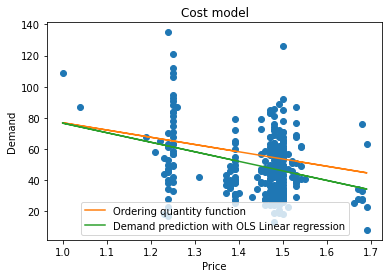

In [63]:
# perform the first step: ordering quantity estimation
D = np.array(train.loc[train['UPC'] == 1111009477, 'UNITS'])
p = np.array(train.loc[train['UPC'] == 1111009477, 'PRICE'])
p=p.reshape(-1,1)

n = len(D)
c = 0.3*np.mean(test.loc[test['UPC'] == 1111009477, 'BASE_PRICE']) #cost per unit 

objC, betaC0, betaC1 = costModel(sampleSize = n, procurementCost = c)
print("Objective:",objC)
print('Estimation of a:', betaC0)
print('Estimation of b:', betaC1)

print('\nOrdering quantity - price function: D = ', round(betaC0,0),'+', round(betaC1,2),'* p')

# OLS Linear regression for comparison
reg = linear_model.LinearRegression().fit(p, D)
coef2 = reg.coef_
coef1 = reg.intercept_

#Plot
plt.plot(p,D,'o')
plt.plot(p, betaC0 + betaC1*p, label='Ordering quantity function')
plt.plot(p, coef1 + coef2*p, label = 'Demand prediction with OLS Linear regression')
plt.legend(loc = 8)
plt.xlabel('Price')
plt.ylabel('Demand')
plt.title('Cost model')
plt.show()

In [64]:
# perform the second step: optimal price and quantity optimization
optV, optP, optQ, optVDD, optPDD, optQDD = DDNV_main(sampleSize = n, procurementCost = c, 
                                                     estimationModel = 'cost', nonStockOut = None, 
                                                     priceUpperBound = max(p))


Ordering quantity parameters: 123.53333333333333 -46.666666666666664
Basic approach: 56.161149420650595 1.5501227106227107 51.194273504273525
Data-driven approach: 38.770655455970015 1.4222471476248673 56.6284664441729 



To evaluate the out-of-sample performance, we have to estimate the true demand at the optimal price p and calculate the expected single-period profit. We will assume that this estimation can be obtained by OLS regression over the whole period (2009 - 2011).

In [65]:
testD = np.array(test.loc[test['UPC'] == 1111009477, 'UNITS'])
testp = np.array(test.loc[test['UPC'] == 1111009477, 'PRICE'])
testp = testp.reshape(-1,1)

# do regression over the whole period
reg = linear_model.LinearRegression().fit(testp, testD)
coef2 = reg.coef_
coef1 = reg.intercept_

#estimated demand at optimal price found from each approach
outSampleD = coef1 + coef2 * optP #basic approach
outSampleDDD = coef1 + coef2 * optPDD #data-driven approach

#expected single-period profit
profitD = optP*min(outSampleD, optQ) - c*optQ #basic approach
profitDDD = optPDD*min(outSampleDDD, optQDD) - c*optQDD #DD approach

print(profitD, profitDDD)

[46.30255589] [47.10040582]


Finally, we will do the same process with all available products in the data set to compare the performance of both approaches in each product. Additionally, for each product we also consider the R square score to get the idea of how well the demand of this product can be explained by the linear relationship with price. The purpose is to see in which case each approach will perform better than the other.

In [68]:

productSet = list(set(test.UPC))
caseResult = pd.DataFrame(index = range(len(productSet)), columns = ['Product', 'R square','In-sample Profit (Basic)', 
                                                                    'In-sample Profit (DD)', 'Out-of-sample Profit (Basic)',
                                                                   'Out-of-sample Profit (DD)'])
idx = 0
products = []
for product in productSet:
    print(product)

    D = np.array(train.loc[train['UPC'] == product, 'UNITS'])
    p = np.array(train.loc[train['UPC'] == product, 'PRICE'])
    p=p.reshape(-1,1)

    n = len(D)
    c = 0.3*np.mean(test.loc[test['UPC'] == product, 'BASE_PRICE'])

    objC, betaC0, betaC1 = costModel(sampleSize = n, procurementCost = c)

    reg = linear_model.LinearRegression().fit(p, D)
    coef2 = reg.coef_
    coef1 = reg.intercept_

    optV, optP, optQ, optVDD, optPDD, optQDD = DDNV_main(sampleSize = n, procurementCost = c, estimationModel = 'cost', 
                                                         nonStockOut = None, priceUpperBound = max(p))


    testD = np.array(test.loc[test['UPC'] == product, 'UNITS'])
    testp = np.array(test.loc[test['UPC'] == product, 'PRICE'])
    testp = testp.reshape(-1,1)

    testReg = linear_model.LinearRegression().fit(testp, testD)
    testCoef2 = testReg.coef_
    testCoef1 = testReg.intercept_
    Rsquare = testReg.score(testp, testD)

    outSampleD = coef1 + coef2 * optP
    outSampleDDD = coef1 + coef2 * optPDD

    profitD = optP*min(outSampleD, optQ) - c*optQ
    profitDDD = optPDD*min(outSampleDDD, optQDD) - c*optQDD

    caseResult.iloc[idx,:] = [product, Rsquare, optV, optVDD, profitD, profitDDD]
    idx+=1

    products.append(product)
print(caseResult)

1111038080

Ordering quantity parameters: 7.476510067114095 -1.3422818791946316
Basic approach: 8.48013345845538 3.0564965831435065 3.3738300897402587
Data-driven approach: 5.720400652000403 3.1487740847423424 5.8942629735002345 

1111035398

Ordering quantity parameters: 3.0 0.0
Basic approach: [10.52263271] [4.49] [3.]
Data-driven approach: [10.52263271] [4.49] [3.] 

1111085319

Ordering quantity parameters: 74.1818181818182 -27.27272727272728
Basic approach: 31.875148614598142 1.6389100642398287 29.484270975277415
Data-driven approach: 21.5445584163012 1.5055243688216031 31.212971759410742 

1600027527

Ordering quantity parameters: 216.2689075630252 -55.46218487394958
Basic approach: 123.55439852523043 2.4068379953379955 82.78041370394311
Data-driven approach: 94.30294960665846 2.2887219748429337 86.55827702551738 

1600027528

Ordering quantity parameters: 168.29 -31.0
Basic approach: 126.54206320704522 3.408313172043011 62.632291666666646
Data-driven approach: 105.07578361574758

Data-driven approach: 65.31867704855313 2.5092862377532654 53.28569775515972 

7110410455

Ordering quantity parameters: 10.166666666666664 -2.083333333333332
Basic approach: 9.046438505657372 2.796183673469389 4.341284013605443
Data-driven approach: 4.801530629741289 2.403839339995328 5.158668041676365 

1111009497

Ordering quantity parameters: 110.77777777777777 -44.44444444444444
Basic approach: 46.2022299382716 1.4729166666666667 45.31481481481481
Data-driven approach: 33.177297878660916 1.370198514620538 49.43562157242121 

3800031838

Ordering quantity parameters: 204.425 -57.50000000000001
Basic approach: 100.15086960785864 2.2354620147099897 75.88593415417557
Data-driven approach: 71.96969349009507 2.10458869743494 77.53614989749033 

1111009507

Ordering quantity parameters: -10.249999999999982 24.99999999999999
Basic approach: [39.59530621] [1.69] [32.]
Data-driven approach: [39.59530621] [1.69] [32.] 

7110410470

Ordering quantity parameters: 9.975 -2.5
Basic approach: 6.6

In [69]:
selectResult = caseResult.loc[caseResult["In-sample Profit (DD)"] != 0].dropna()

In [70]:
print(selectResult)

        Product    R square In-sample Profit (Basic) In-sample Profit (DD)  \
0    1111038080    0.198979                  8.48013                5.7204   
1    1111035398   0.0103532       [10.5226327077748]    [10.5226327077748]   
2    1111085319  0.00592924                  31.8751               21.5446   
3    1600027527    0.487013                  123.554               94.3029   
4    1600027528    0.710852                  126.542               105.076   
5   88491201426     0.26359                  66.1289               48.6539   
6   88491201427    0.361828                  59.0442               47.8461   
7    2840002333    0.296178                  22.3261               17.7735   
8    2840004768    0.525963                  29.9047               23.4809   
9    1111085345   0.0476638                  41.1926                30.591   
10   2840004770    0.410398                  18.1139               14.0784   
11   1111087395    0.221553                   27.321            

There are 25 products that the performance of Data-driven approach is better than Basic approach in terms of Out-of-sample profit in this specific case study. It is noticeable that most of products that DD approach performs better have relatively lower R square compared to the products that Basic approach performs better. It may indicate that DD approach is more robust than Basic approach in case that the relationship between demand and price is not captured well by the linear regression function.
